In [56]:
#Data Preparation

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error


## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.


## Load Data

In [57]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False)
df.shape

(412698, 53)

## EDA

In [58]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

<Axes: ylabel='Frequency'>

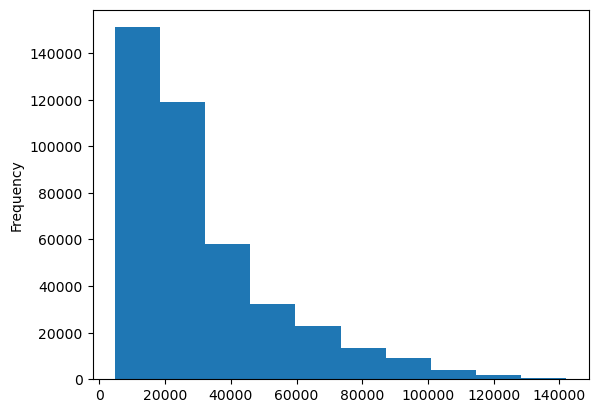

In [60]:
df.SalePrice.plot.hist()

## Parsing dates

In [61]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False, parse_dates=['saledate'])

In [62]:
df['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

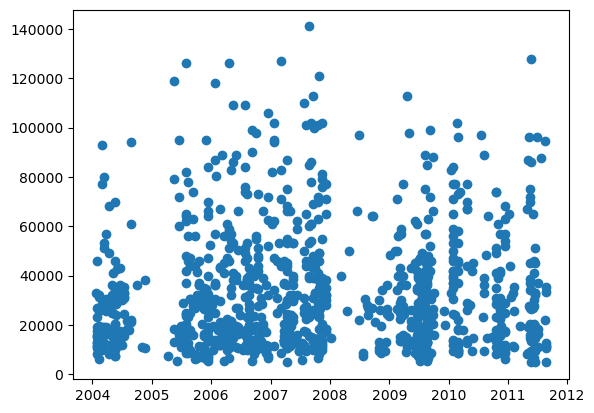

In [63]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [64]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [65]:
#Sort DF by SaleDate

df.sort_values(by=['saledate'], inplace = True, ascending = True)

In [66]:
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

In [67]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

# Now we've enriched our DataFrame with date time features, we remove 'saledate'
df_tmp.drop("saledate", axis=1, inplace=True)

## Convert string to categories

In [68]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [69]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [70]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

## Fill missing values 

### Fill numerical missing values first

In [71]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [73]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [74]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [75]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [76]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [77]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [78]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [79]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [80]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [81]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## Modelling 

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [82]:
# Let's build a machine learning model 
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

RandomForestRegressor(n_jobs=-1, random_state=42)

In [83]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970562

**Question:** Why doesn't the above metric hold water? (why isn't the metric reliable)

### Splitting data into train/validation sets

In [84]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [85]:
# Split data into training (not 2012) and validation (2012)
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [86]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [87]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [88]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [89]:
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [90]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyerparameter tuning with RandomizedSearchCV

In [91]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [92]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [93]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6044.4054628808235,
 'Valid MAE': 7387.694689503134,
 'Training RMSLE': 0.2746602805235643,
 'Valid RMSLE': 0.299892210365413,
 'Training R^2': 0.8365694956443092,
 'Valid R^2': 0.8209322874442639}

### Train a model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [94]:
# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [95]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [96]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 6044.4054628808235,
 'Valid MAE': 7387.694689503134,
 'Training RMSLE': 0.2746602805235643,
 'Valid RMSLE': 0.299892210365413,
 'Training R^2': 0.8365694956443092,
 'Valid R^2': 0.8209322874442639}

## Make predictions on test data

In [98]:
# Import the test data
df_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [101]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [102]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [104]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [105]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [108]:
df_test = df_test.reindex(columns=list(X_train.columns))

In [109]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [110]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [111]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [112]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

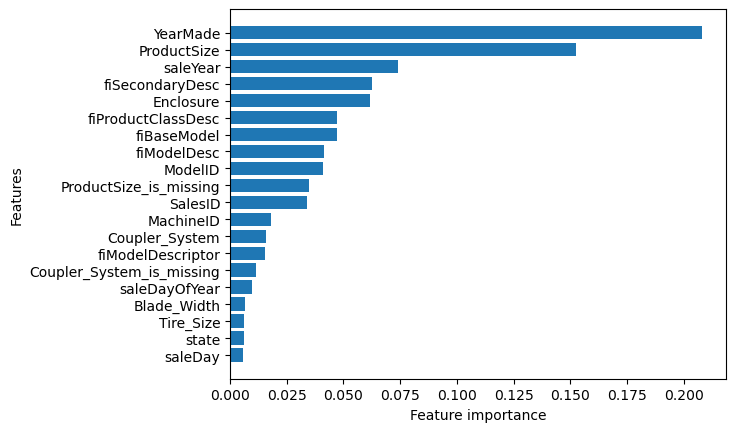

In [113]:
plot_features(X_train.columns, ideal_model.feature_importances_)